# Montar carpeta de drive

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')
 !pip install scikit-learn
 !pip install opencv-python
 !pip install matplotlib
 !conda install Pillow
!pip install mlxtend

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))




  Using cached mlxtend-0.23.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached mlxtend-0.23.1-py3-none-any.whl (1.4 MB)
Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Num GPUs Available:  1


# Clasificador de imágenes

In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
%matplotlib inline

# Configuración de parámetros

In [4]:
width_shape = 224
height_shape = 224
num_classes = 24
epochs = 100
batch_size = 32
image_shape = (224,224,3)

# Path de dataset

In [5]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\NA\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\NA\valid'

# Generador de imágenes (entrenamiento y validación) VGG16

In [6]:
# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Últimos cambios añadidos de una consulta
    rotation_range=10,
    zoom_range=0.1,  # Reducido de 0.2 a 0.1
    width_shift_range=0.1,  # Reducido de 0.2 a 0.1
    height_shift_range=0.1,  # Reducido de 0.2 a 0.1
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest', # Últimos cambios añadidos de una consulta
    # preprocessing_function=preprocess_input comentamos esto que es de vgg16
    )

valid_datagen = ImageDataGenerator(rescale=1./255) # Sin aumentos de datos para la validación

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 3860 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


# Entrenamiento de modelo VGG16

In [7]:
import sys
from PIL import Image
sys.modules['Image'] = Image 
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Load pre-trained VGG16 model
image_input = Input(shape=(width_shape, height_shape, 3))
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Creating final model
custom_vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Freezing layers from original VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Compilando el modelo con Adam
custom_vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Definir ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con ModelCheckpoint
model_history = custom_vgg_model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size),
    callbacks=[checkpoint,reduce_lr,early_stopping])

# Guardar el modelo
custom_vgg_model.save('custom_vgg_model.h5')

Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 3.3065 - accuracy: 0.2883
Epoch 1: val_accuracy improved from -inf to 0.72500, saving model to best_model.h5
121/121 [==============================] - 47s 334ms/step - loss: 3.3065 - accuracy: 0.2883 - val_loss: 1.2969 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 1.5879 - accuracy: 0.5184
Epoch 2: val_accuracy improved from 0.72500 to 0.74167, saving model to best_model.h5
121/121 [==============================] - 34s 281ms/step - loss: 1.5879 - accuracy: 0.5184 - val_loss: 0.9248 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.5816
Epoch 3: val_accuracy improved from 0.74167 to 0.81667, saving model to best_model.h5
121/121 [==============================] - 35s 286ms/step - loss: 1.3665 - accuracy: 0.5816 - val_loss: 0.7018 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 4/100
1

# Generador de imágenes (entrenamiento, validación y test) INCEPTION RESTETV2

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.resnet_v2 import preprocess_input

# # Data generators with data augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest', # Últimos cambios añadidos de una consulta
#     )

# valid_datagen = ImageDataGenerator(rescale=1./255) # Sin aumentos de datos para la validación

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(width_shape, height_shape),
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=True)

# validation_generator = valid_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(width_shape, height_shape),
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=True)


# for _ in range(3):
#     img, label = train_generator.next()
#     plt.imshow(img[0])
#     plt.show()

# INCEPTION RESTETV2


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
# from tensorflow import keras
# from keras.applications.resnet_v2 import ResNet152V2

# # Load pre-trained ResNet152V2 model
# resnet_model = ResNet152V2(input_shape=image_shape, include_top=False, weights='imagenet')

# # Freeze the pre-trained layers
# for layer in resnet_model.layers:
#     layer.trainable = False

# # Add custom classification layers
# x = Flatten()(resnet_model.output)
# x = Dense(units=512, activation='relu')(x)
# x = BatchNormalization()(x)
# output = Dense(units=num_classes, activation='softmax')(x)

# # Create custom model
# custom_resnet_model = Model(inputs=resnet_model.input, outputs=output)

# custom_resnet_model.summary()

# # Compile the model
# custom_resnet_model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Fit the model
# from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=10)

# custom_resnet_model_history = custom_resnet_model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=epochs,
#     verbose=1,
#     callbacks=[early_stop]
# )

# # Save the model
# custom_resnet_model.save('custom_resnet_model.h5')

# Grabar modelo en disco

In [8]:
custom_vgg_model.save("custom_vgg_model.h5")
#custom_resnet_model.save("custom_resnetv2_model.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [9]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

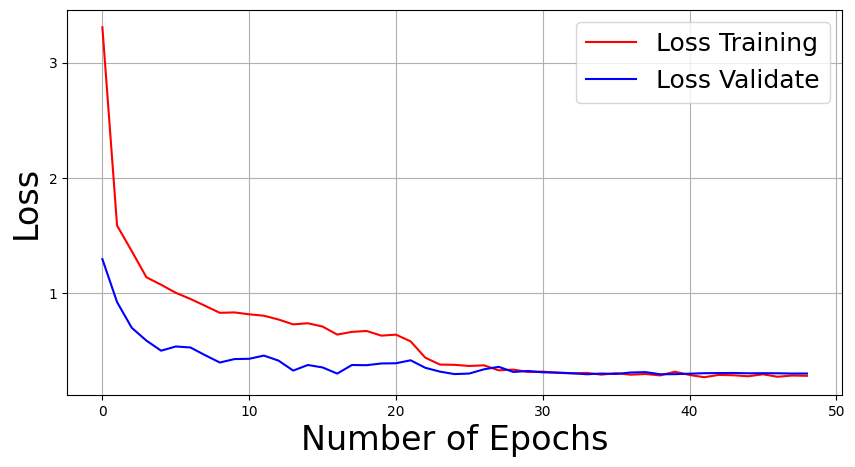

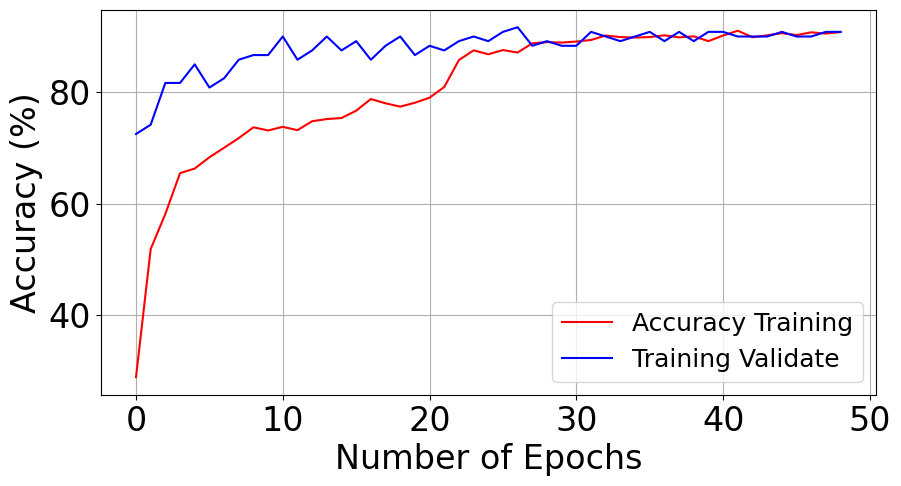

In [10]:
# num_epochs_done = len(custom_resnet_model_history.history['loss'])

# plotTraining(custom_resnet_model_history,num_epochs_done,"loss")
# plotTraining(custom_resnet_model_history,num_epochs_done,"accuracy")
# plotTraining(custom_resnet_model_history,num_epochs_done,"val_loss")
# plotTraining(custom_resnet_model_history,num_epochs_done,"val_accuracy")

num_epochs_done = len(model_history.history['loss'])

plotTraining(model_history,num_epochs_done,"loss")
plotTraining(model_history,num_epochs_done,"accuracy")
plotTraining(model_history,num_epochs_done,"val_loss")
plotTraining(model_history,num_epochs_done,"val_accuracy")


# Predicción usando el modelo entrenado

AFRICAN OYSTER CATCHER


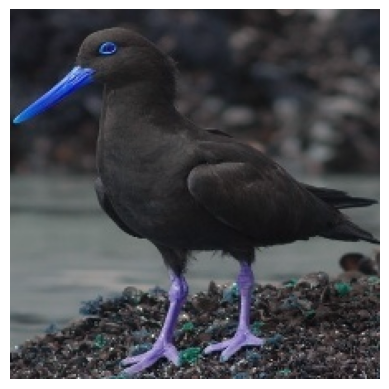

In [12]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

names = ['ABBOTTS BABBLER',
          'ABBOTTS BOOBY',
          'ABYSSINIAN GROUND HORNBILL',
          'AFRICAN CROWNED CRANE',
          'AFRICAN EMERALD CUCKOO',
          'AFRICAN FIREFINCH',
          'AFRICAN OYSTER CATCHER',
          'AFRICAN PIED HORNBILL',
          'AFRICAN PYGMY GOOSE',
          'ALBATROSS',
          'ALBERTS TOWHEE',
          'ALEXANDRINE PARAKEET',
          'ALPINE CHOUGH',
          'ALTAMIRA YELLOWTHROAT',
          'AMERICAN AVOCET',
          'AMERICAN BITTERN',
          'AMERICAN COOT',
          'AMERICAN DIPPER',
          'AMERICAN FLAMINGO',
          'AMERICAN GOLDFINCH',
          'AMERICAN KESTREL',
          'AMERICAN PIPIT',
          'AMERICAN REDSTART',
          'AMERICAN ROBIN']

# nombres de las clases
# names = ['AGUJA COLINERA', 'ALCA COMÚN', 'AVEFRÍA EUROPEA','AVIÓN ROQUERO', 'ESTORNINO PINTO', 'FLAMENCO COMUN','FOCHA COMUN','GAVIOTA REIDORA','GOLONDRINA COMUN', 'PARDELA BALEAR', 'PATO CUCHARÓN NORTEÑO', 'VENCEJO COMÚN']

# cargar el modelo
modelt = load_model("custom_vgg_model.h5")
# modelt = load_model("custom_resnetv2_model.h5")

# ruta de la imagen
imaget_path = r'C:\Users\johns\Desktop\TFG\NA\test\AFRICAN OYSTER CATCHER\2.jpg'

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

# preprocesar la imagen
xt = imaget / 255.0  # Normalizar la imagen

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 120 images belonging to 24 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_4436\2440151141.py:52: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\

              precision    recall  f1-score   support

           0     1.0000    0.2000    0.3333         5
           1     1.0000    0.4000    0.5714         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    0.6000    0.7500         5
           6     0.8333    1.0000    0.9091         5
           7     1.0000    1.0000    1.0000         5
           8     0.8000    0.8000    0.8000         5
           9     0.8333    1.0000    0.9091         5
          10     0.0000    0.0000    0.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    0.8000    0.8889         5
          13     0.0000    0.0000    0.0000         5
          14     1.0000    1.0000    1.0000         5
          15     1.0000    1.0000    1.0000         5
          16     1.0000    0.6000    0.7500         5
          17     0.0000    

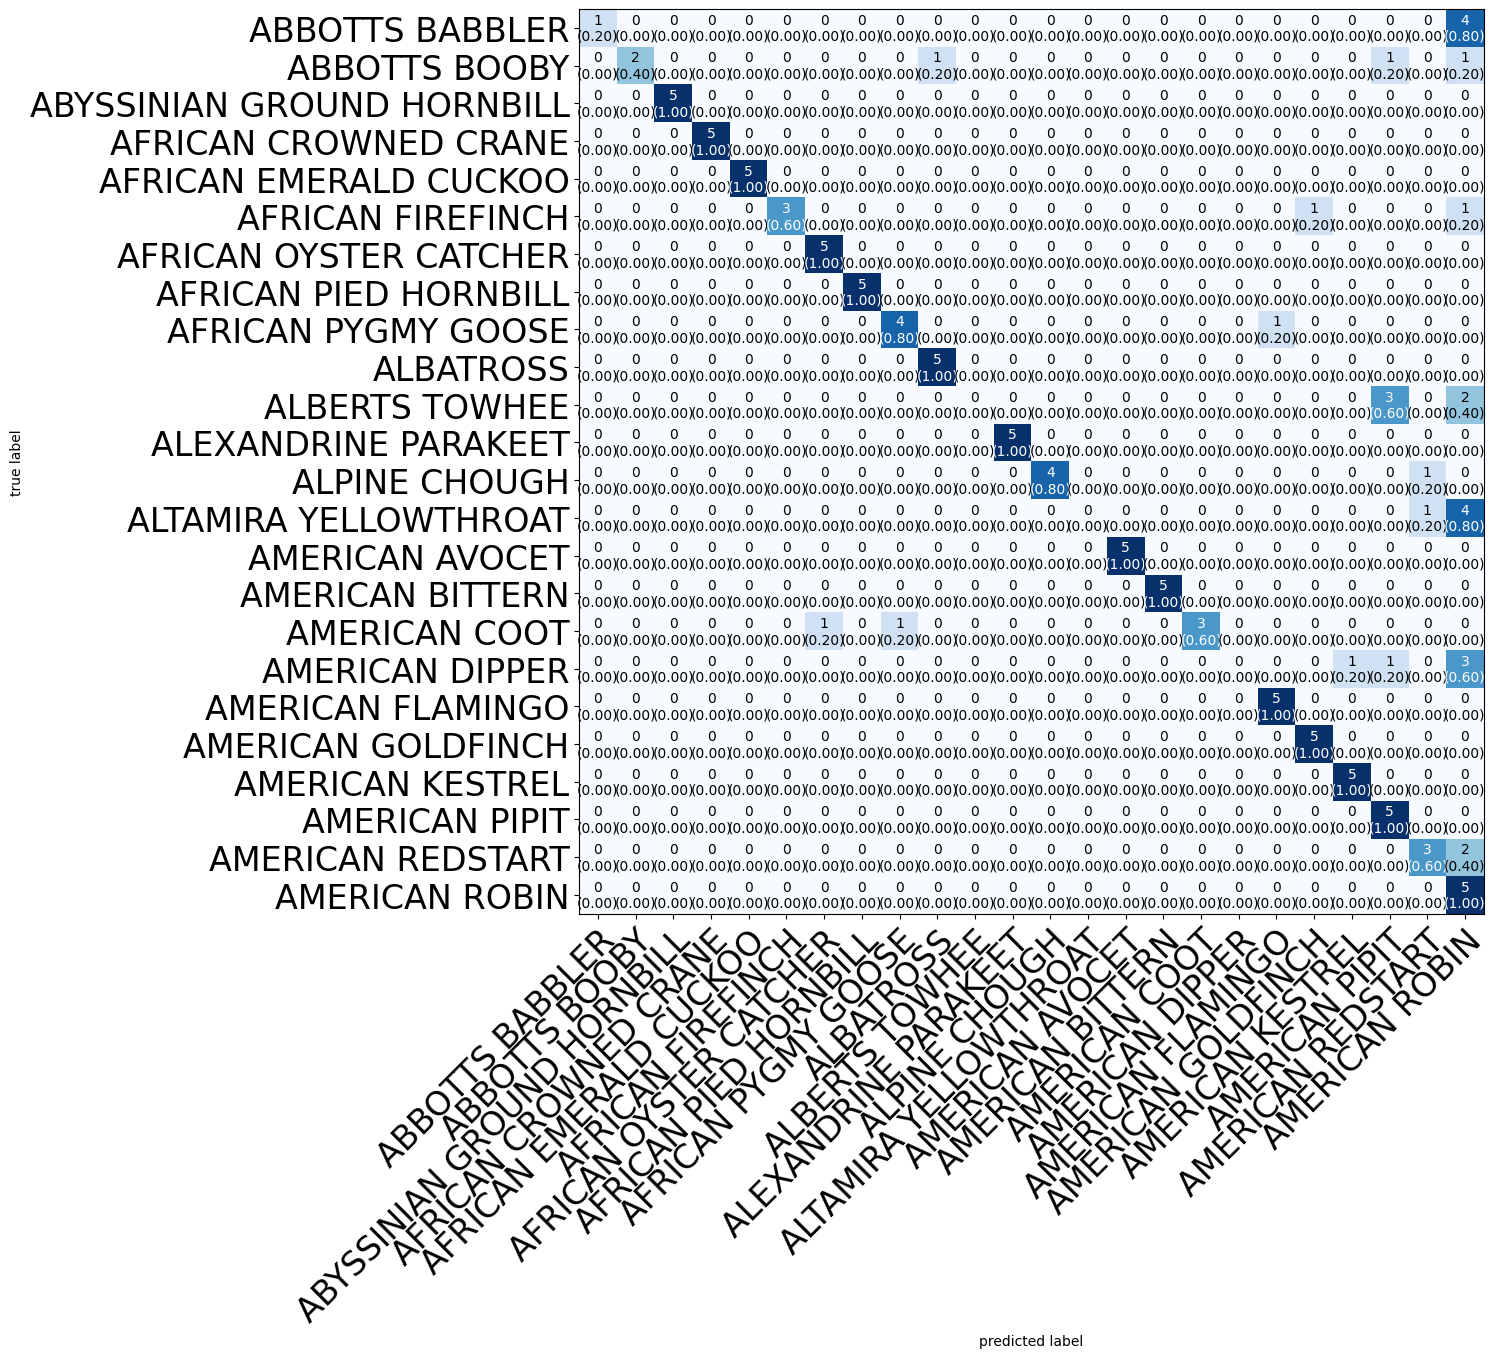

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

names = ['ABBOTTS BABBLER',
          'ABBOTTS BOOBY',
          'ABYSSINIAN GROUND HORNBILL',
          'AFRICAN CROWNED CRANE',
          'AFRICAN EMERALD CUCKOO',
          'AFRICAN FIREFINCH',
          'AFRICAN OYSTER CATCHER',
          'AFRICAN PIED HORNBILL',
          'AFRICAN PYGMY GOOSE',
          'ALBATROSS',
          'ALBERTS TOWHEE',
          'ALEXANDRINE PARAKEET',
          'ALPINE CHOUGH',
          'ALTAMIRA YELLOWTHROAT',
          'AMERICAN AVOCET',
          'AMERICAN BITTERN',
          'AMERICAN COOT',
          'AMERICAN DIPPER',
          'AMERICAN FLAMINGO',
          'AMERICAN GOLDFINCH',
          'AMERICAN KESTREL',
          'AMERICAN PIPIT',
          'AMERICAN REDSTART',
          'AMERICAN ROBIN']

# nombres de las clases
# names = ['AGUJA COLINERA', 'ALCA COMÚN', 'AVEFRÍA EUROPEA','AVIÓN ROQUERO', 'ESTORNINO PINTO', 'FLAMENCO COMUN',
        #  'FOCHA COMUN','GAVIOTA REIDORA','GOLONDRINA COMUN', 'PARDELA BALEAR', 'PATO CUCHARÓN NORTEÑO', 'VENCEJO COMÚN']

test_data_dir = r'C:\Users\johns\Desktop\TFG\NA\test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False)

custom_Model= load_model("custom_vgg_model.h5")

predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)

#show_normed: es para normalizar la salida de la matriz de confusion entre 0 y 1.
plot_confusion_matrix(conf_mat=matc, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [16]:
print(y_real)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23]


In [17]:
print(y_pred)

[23 23 23 23 23  1  1 23  9 21  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4 23 19 23 23 23  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 21 23 21 23 21 11 11 11 11 11 12 12 22 12 23 23 23 23 23 23 14 14
 14 14 14 15 15 15 15 15  8 16  6 16 16 23 23 20 23 21 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 23 23 22 23 23 23 23 23]
